In [180]:
import os
# 打印当前工作目录
print("Current working directory:", os.getcwd())
import sys
print("current python environment:", sys.executable)

import pandas as pd
from datetime import datetime
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx
import matplotlib.pyplot as plt
import mapclassify
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
import numpy as np


Current working directory: /Users/libowen/SD3rd/RP/code
current python environment: /Users/libowen/miniforge3/envs/windmap/bin/python


In [2]:
# 读取主数据
df = pd.read_parquet("energinet/masterdatawind.parquet")
pd.set_option('display.max_columns', None)
df.head()  # 默认前5行

GSRN Turbine_short_name                    Turbine_name  \
0  000000000000000000          348-80052  Husstandsmølle v/ Morten Mørup   
1  570714700000000027          791-079/1                     Parkstien 1   
2  570714700000000027          791-079/1                     Damhusåen 2   
3  570714700000000034          791-079/2                     Parkstien 1   
4  570714700000000034          791-079/2                     Damhusåen 1   

  Turbine_type         Parent_GSRN                In_service  \
0            H                None 2012-08-11 00:00:00+00:00   
1            M  570714700000050459 1993-02-03 00:00:00+00:00   
2            M  570714700000050459 1993-02-03 00:00:00+00:00   
3            M  570714700000050459 1993-02-03 00:00:00+00:00   
4            M  570714700000050459 1993-02-03 00:00:00+00:00   

                Out_service BBR_municipal Placement       UTM_x        UTM_y  \
0 2014-10-01 00:00:00+00:00           760      None         NaN          NaN   
1                       NaT           101      LAND  720898.353  6171174.877   
2                       NaT           101      LAND  720898.353  6171174.877   
3                       NaT           101      LAND  720993.352  6171226.877   
4                       NaT           101      LAND  720993.352  6171226.877   

   UTM_precision  Capacity_kw     Model Manufacturer  Rotor_diameter  \
0            NaN         11.0  44707813     44707128            13.0   
1            1.0        225.0  44707587     44707106            27.0   
2            1.0        225.0  44707587     44707106            27.0   
3            1.0        225.0  44707587     44707106            27.0   
4            1.0        225.0  44707587     44707106            27.0   

   Navhub_height  Fullload_amount  Fullload_quota Fullload_datetime  \
0           18.2              NaN             NaN               NaT   
1           30.0              NaN         15000.0               NaT   
2           30.0              NaN         15000.0               NaT   
3           30.0              NaN         15000.0               NaT   
4           30.0              NaN         15000.0               NaT   

  Actor_short_name     Actor_name             Valid_to           Valid_from  
0       EGENPROD-W  Egenproducent  2014-10-31 23:59:59  2012-07-31 23:00:00  
1             None           None                 None                 None  
2             None           None                 None                 None  
3             None           None                 None                 None  
4             None           None                 None                 None

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85150 entries, 0 to 85149
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   GSRN                85150 non-null  object             
 1   Turbine_short_name  85150 non-null  object             
 2   Turbine_name        85150 non-null  object             
 3   Turbine_type        85150 non-null  object             
 4   Parent_GSRN         4995 non-null   object             
 5   In_service          85115 non-null  datetime64[ms, UTC]
 6   Out_service         5289 non-null   datetime64[ms, UTC]
 7   BBR_municipal       85150 non-null  object             
 8   Placement           69333 non-null  object             
 9   UTM_x               62396 non-null  float64            
 10  UTM_y               62396 non-null  float64            
 11  UTM_precision       62396 non-null  float64            
 12  Capacity_kw         85150 non-nu

In [32]:
# 处理时间字段
df['In_service'] = pd.to_datetime(df['In_service'], errors='coerce')
df['Out_service'] = pd.to_datetime(df['Out_service'], errors='coerce')
df['In_service'] = df['In_service'].dt.tz_localize(None)
df['Out_service'] = df['Out_service'].dt.tz_localize(None)

today = pd.Timestamp(datetime.today().date())

# 判断是否仍在运行
df['status'] = df.apply(lambda row: 'Available' if row['In_service'] <= today and 
                        (pd.isna(row['Out_service']) or row['Out_service'] > today) 
                        else 'Retired', axis=1)

In [33]:

# 创建 GeoDataFrame（EPSG:25832 是 UTM zone 32N）
gdf = gpd.GeoDataFrame(df, 
    geometry=[Point(xy) for xy in zip(df['UTM_x'], df['UTM_y'])],
    crs="EPSG:25832")

# 转换为经纬度（EPSG:4326）
gdf = gdf.to_crs("EPSG:4326")

In [34]:
available = gdf[(gdf['status'] == 'Available')]
retired = gdf[(gdf['status'] == 'Retired')]

print(f"Available turbines: {len(available)}")
print(f"Retired turbines: {len(retired)}")
# 只显示包含 UTM 坐标的前几条记录
retired_valid = retired[retired['UTM_x'].notnull() & retired['UTM_y'].notnull()]
retired_valid[['GSRN', 'Turbine_name', 'UTM_x', 'UTM_y']].head()

Available turbines: 79826
Retired turbines: 5324


GSRN   Turbine_name     UTM_x      UTM_y
11  570714700000000072  Avedøre Holme  717288.0  6167432.0
14  570714700000000089  Avedøre Holme  717423.0  6167422.0
16  570714700000000096  Avedøre Holme  717556.0  6167412.0
17  570714700000000102  Avedøre Holme  717690.0  6167403.0
18  570714700000000102  Avedøre Holme  717690.0  6167403.0

In [35]:
# 总风机数量（每一行一条记录）
total_turbines = len(df)
total_available_turbines = len(available)

# 按 Turbine_type 分类
available_type_counts = available['Turbine_type'].value_counts()

print(f"在役风机总数（已过滤）: {total_available_turbines}\n")
print("按 Turbine_type 分类的数量：")
print(available_type_counts)

在役风机总数（已过滤）: 79826

按 Turbine_type 分类的数量：
Turbine_type
W    54289
H    15495
P     6342
M     3700
Name: count, dtype: int64


In [13]:
pd.set_option('display.max_columns', None)
outlier = available[(available['Capacity_kw'] == 0 )& (available['Turbine_type'] != 'P')]
print(f"0kw turbine: {len(outlier)}")
outlier.head(10)


0kw turbine: 3


GSRN Turbine_short_name               Turbine_name  \
66119  570715000000058455         232-TVIS/1  Torrild Vindmøllelaug I/S   
66132  570715000000058462         232-TVIS/2  Torrild Vindmøllelaug I/S   
66143  570715000000058479         232-TVIS/3  Torrild Vindmøllelaug I/S   

      Turbine_type         Parent_GSRN In_service Out_service BBR_municipal  \
66119            M  570715000000058486 2002-12-20         NaT           727   
66132            M  570715000000058486 2002-12-20         NaT           727   
66143            M  570715000000058486 2002-12-20         NaT           727   

      Placement     UTM_x      UTM_y  UTM_precision  Capacity_kw     Model  \
66119      LAND  564684.0  6204254.0            9.0          0.0  44707413   
66132      LAND  564680.0  6204504.0            9.0          0.0  44707413   
66143      LAND  564677.0  6204754.0            9.0          0.0  44707413   

      Manufacturer  Rotor_diameter  Navhub_height  Fullload_amount  \
66119     44707079            52.0           49.0              NaN   
66132     44707079            52.0           49.0              NaN   
66143     44707079            52.0           49.0              NaN   

       Fullload_quota Fullload_datetime Actor_short_name Actor_name Valid_to  \
66119      19800000.0               NaT             None       None     None   
66132      19800000.0               NaT             None       None     None   
66143      19800000.0               NaT             None       None     None   

      Valid_from     status                   geometry  
66119       None  Available   POINT (10.0366 55.97924)  
66132       None  Available   POINT (10.0366 55.98149)  
66143       None  Available  POINT (10.03661 55.98373)

In [ ]:
small_turbines = available[(available['Capacity_kw'] < 20)& (available['Turbine_type'].isin (['W', 'M']))]
print(f"风机容量 < 20kW 的数量: {len(small_turbines)}")
small_turbines[['Turbine_name', 'Capacity_kw', "Turbine_type",'In_service', 'Out_service','Manufacturer']]

风机容量 < 20kW 的数量: 0


Empty DataFrame
Columns: [Turbine_name, Capacity_kw, Turbine_type, In_service, Out_service, Manufacturer]
Index: []

最小值: 1.0
每个容量区间的风机数量：
[1.0, 100.0): 2478 turbines
[100.0, 500.0): 16370 turbines
[500.0, 1500.0): 34388 turbines
[1500.0, 3000.0): 2987 turbines
[3000.0, 8600.0): 1762 turbines


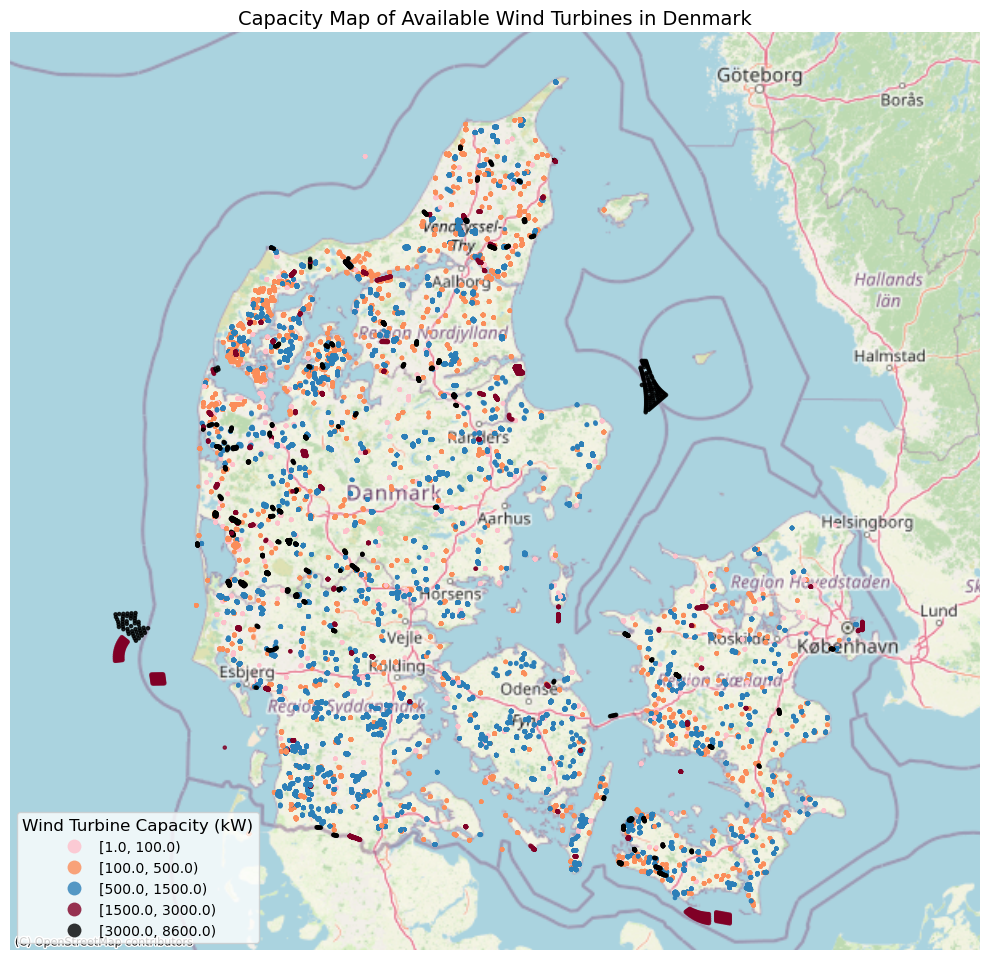

In [ ]:

# 过滤掉容量为 0 的风机
available = gdf[
    (gdf['status'] == 'Available') &
    (gdf.geometry.notnull()) &
    (gdf['Capacity_kw'].notnull()) &
    (gdf['Capacity_kw'] > 0)&
    (gdf['Turbine_type'].isin(['W', 'M']))
].copy()

# 转换为 Web Mercator 坐标
available = available.to_crs(epsg=3857)

min_val = available['Capacity_kw'].min()
print("最小值:", min_val)  

# 设置分类区间（最后一档为 10000 以上）
bins = [1, 100, 500, 1500, 3000, available['Capacity_kw'].max()]

# 使用 pd.cut 将 Capacity_kw 分箱
available['capacity_bin'] = pd.cut(available['Capacity_kw'], bins=bins, right=False,include_lowest=True)

# 统计每个 bin 的风机数量
capacity_counts = available['capacity_bin'].value_counts().sort_index()

# 打印结果
print("每个容量区间的风机数量：")
for interval, count in capacity_counts.items():
    print(f"{interval}: {count} turbines")

# 自定义颜色：从浅绿到深蓝，最后一类为黑色
colors = [
    'pink',  # 橙色
     '#fc8d59',  # 深橙红
    '#41b6c4',  # light cyan
    '#2c7fb8',  # medium blue
    '#253494',  # deep blue
    '#800026',  # dark red
    '#000000'   # black
    ]
cmap = ListedColormap(colors)

# 画图
fig, ax = plt.subplots(figsize=(10, 12))

available.plot(
    ax=ax,
    column='capacity_bin',   
    cmap=cmap,
    markersize=5,
    alpha=0.8,
    legend=True,
    legend_kwds={
        'title': "Wind Turbine Capacity (kW)",
        'loc': 'lower left',
        'fontsize': 10,
        'title_fontsize': 12
    }
)

# 地图范围和底图
ax.set_xlim(760000, 1500000)
ax.set_ylim(7250000, 7950000)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

plt.title("Capacity Map of Available Wind Turbines in Denmark", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

每个十年的风机数量：
1810s: 2 turbines
1970s: 45 turbines
1980s: 7048 turbines
1990s: 33929 turbines
2000s: 14607 turbines
2010s: 2355 turbines


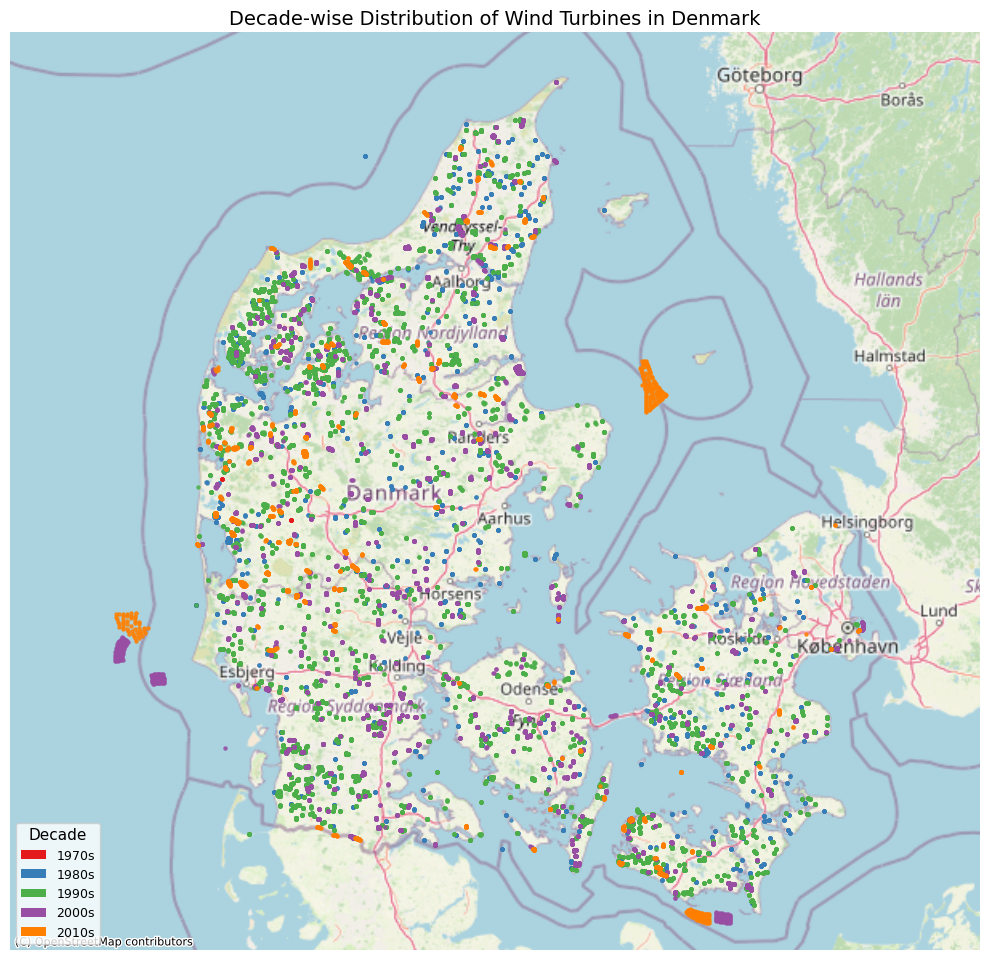

In [ ]:
from matplotlib.patches import Patch


# 重新生成 decade 分类
year_data = available.copy()
year_data['year'] = pd.to_datetime(year_data['In_service'], errors='coerce').dt.year
year_data = year_data[year_data['year'].notnull()].copy()
year_data['decade'] = (year_data['year'] // 10) * 10
# 按 decade 分组并计数
decade_counts = year_data['decade'].value_counts().sort_index()

# 打印每个十年的风机数量
print("每个十年的风机数量：")
for decade, count in decade_counts.items():
    print(f"{int(decade)}s: {count} turbines")
    
year_data = year_data[year_data['decade'] >= 1970].copy()

# 所有年代 & 色彩映射
unique_decades = sorted(year_data['decade'].unique())
colors = [
   '#e41a1c',  # 1970s - red
    '#377eb8',  # 1980s - blue
    '#4daf4a',  # 1990s - green
    '#984ea3',  # 2000s - purple
    '#ff7f00',  # 2010s - orange
    '#ffff33',  # 2020s - yellow
][:len(unique_decades)]

# 映射 decade 到颜色
color_map = dict(zip(unique_decades, colors))
year_data['color'] = year_data['decade'].map(color_map)

# 坐标转换（如未完成）
if year_data.crs.to_epsg() != 3857:
    year_data = year_data.to_crs(epsg=3857)

# 绘图
fig, ax = plt.subplots(figsize=(10, 12))
for decade in unique_decades:
    subset = year_data[year_data['decade'] == decade]
    subset.plot(ax=ax, color=color_map[decade], markersize=5, label=f"{decade}s", alpha=0.8)

# 图例
legend_elements = [Patch(facecolor=color_map[dec], label=f"{dec}s") for dec in unique_decades]
ax.legend(handles=legend_elements, loc='lower left', fontsize=9, title='Decade', title_fontsize=11)

# 地图范围和底图
ax.set_xlim(760000, 1500000)
ax.set_ylim(7250000, 7950000)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

plt.title("Decade-wise Distribution of Wind Turbines in Denmark", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

每个厂商的风机数量（包含 'Other'）：
44707106: 20833 turbines
44707079: 13563 turbines
44707084: 7629 turbines
44707113: 3363 turbines
Other: 2582 turbines
44707135: 2390 turbines
44707112: 2271 turbines
44707078: 2218 turbines
44707122: 1159 turbines
44707133: 1028 turbines
44707110: 950 turbines


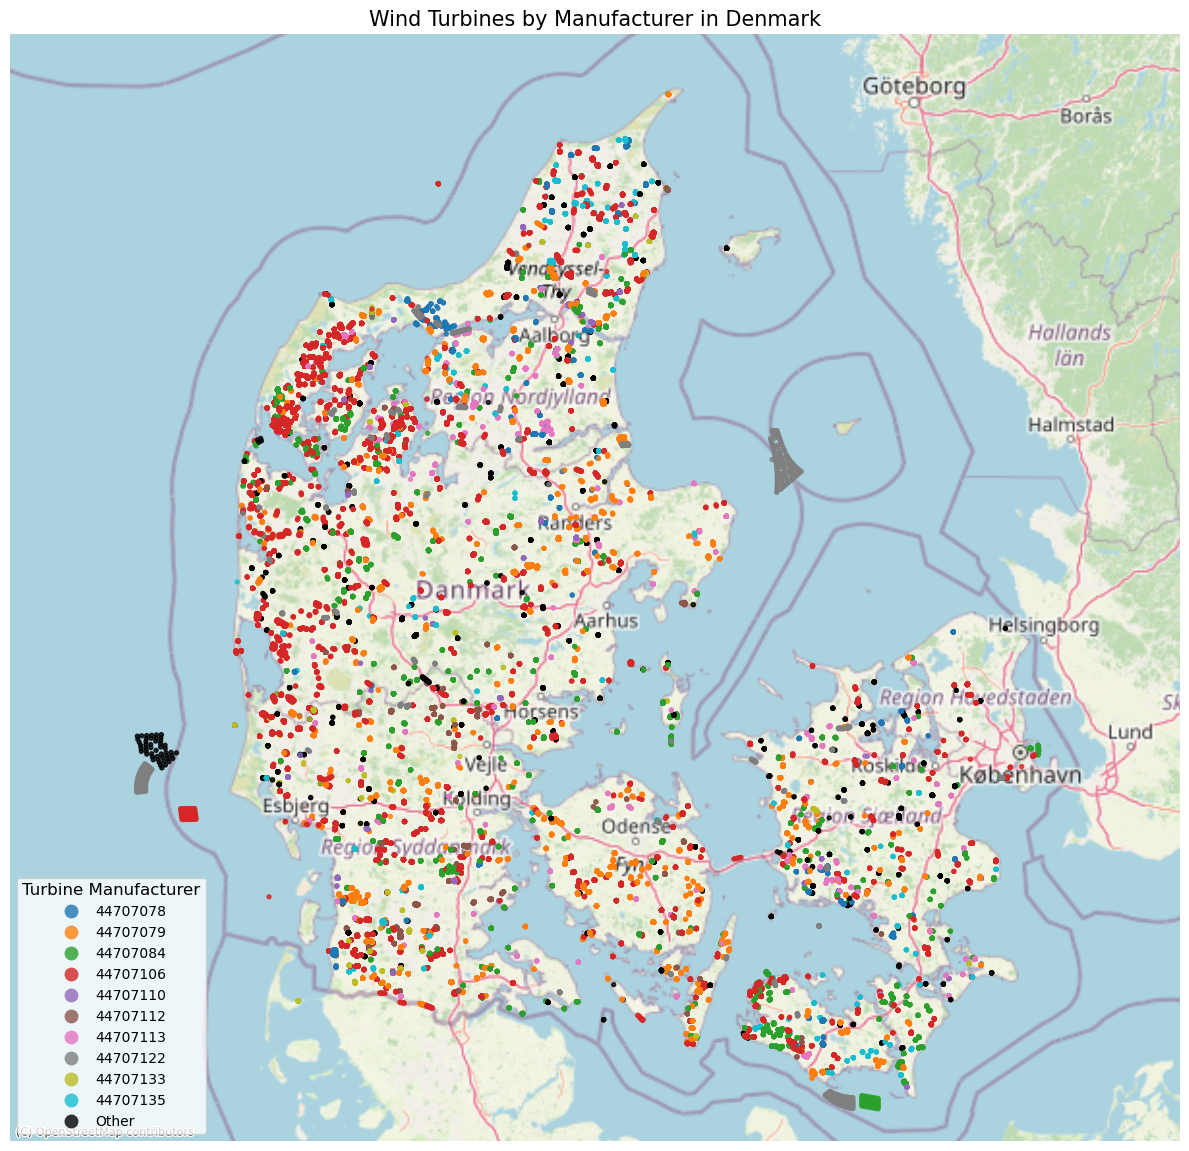

In [109]:

# 按厂商统计数量，选择前10
top_names = available['Manufacturer'].value_counts().nlargest(10).index.tolist()

# 创建新列，只保留前10厂商，其他归为 "Other"
available['manufacturer_group'] = available['Manufacturer'].apply(
    lambda x: x if x in top_names else 'Other'
)

# 统计每组的风机数量
group_counts = available['manufacturer_group'].value_counts()

# 打印结果
print("每个厂商的风机数量（包含 'Other'）：")
for manu, count in group_counts.items():
    print(f"{manu}: {count} turbines")

# 创建颜色映射（确保颜色足够区分）
manufacturer_colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
    '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
    '#bcbd22', '#17becf', '#000000'  # “Other”用黑色
]
cmap = ListedColormap(manufacturer_colors[:len(set(available['manufacturer_group']))])

# 地图可视化
fig, ax = plt.subplots(figsize=(12, 14))

available.plot(
    ax=ax,
    column='manufacturer_group',
    cmap=cmap,
    markersize=8,
    alpha=0.8,
    legend=True,
    legend_kwds={
        'title': "Turbine Manufacturer",
        'loc': 'lower left',
        'fontsize': 10,
        'title_fontsize': 12
    }
)

ax.set_xlim(760000, 1500000)
ax.set_ylim(7250000, 7950000)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.title("Wind Turbines by Manufacturer in Denmark", fontsize=15)
plt.axis("off")
plt.tight_layout()
plt.show()

In [119]:
from shapely.geometry import Point
import math

# 过滤出 P 类风场
p_turbines = gdf[gdf['Turbine_type'] == 'P']

# 检查 geometry 是否为有效点（不是 NaN 和不是空）
valid_p_with_geometry = p_turbines[
    p_turbines.geometry.notnull() &
    p_turbines.geometry.apply(lambda geom: isinstance(geom, Point) and not math.isnan(geom.x) and not math.isnan(geom.y))
]

print(f"P 类风场总数: {len(p_turbines)}")
print(f"P 类风场中有有效坐标的数量: {len(valid_p_with_geometry)}")

# 提取属于风场的风机（M类）
m_turbines = gdf[(gdf['Turbine_type'] == 'M') & gdf['Parent_GSRN'].notnull() & gdf.geometry.notnull()].copy()

# 现在每个 m_turbines 中的 Parent_GSRN 就是其所属风场的标识
# 分组举例：统计每个风场的风机数量
windfarm_stats = m_turbines.groupby('Parent_GSRN').size().reset_index(name='turbine_count')
print(windfarm_stats)

P 类风场总数: 6937
P 类风场中有有效坐标的数量: 0
            Parent_GSRN  turbine_count
0    570714700000005640              3
1    570714700000012037              1
2    570714700000012051              1
3    570714700000012105              6
4    570714700000050008             10
..                  ...            ...
575  570715000000091803              2
576  570715000000258107            111
577  570715000001613493             49
578  570715000001761682              5
579  571313134700404281              4

[580 rows x 2 columns]


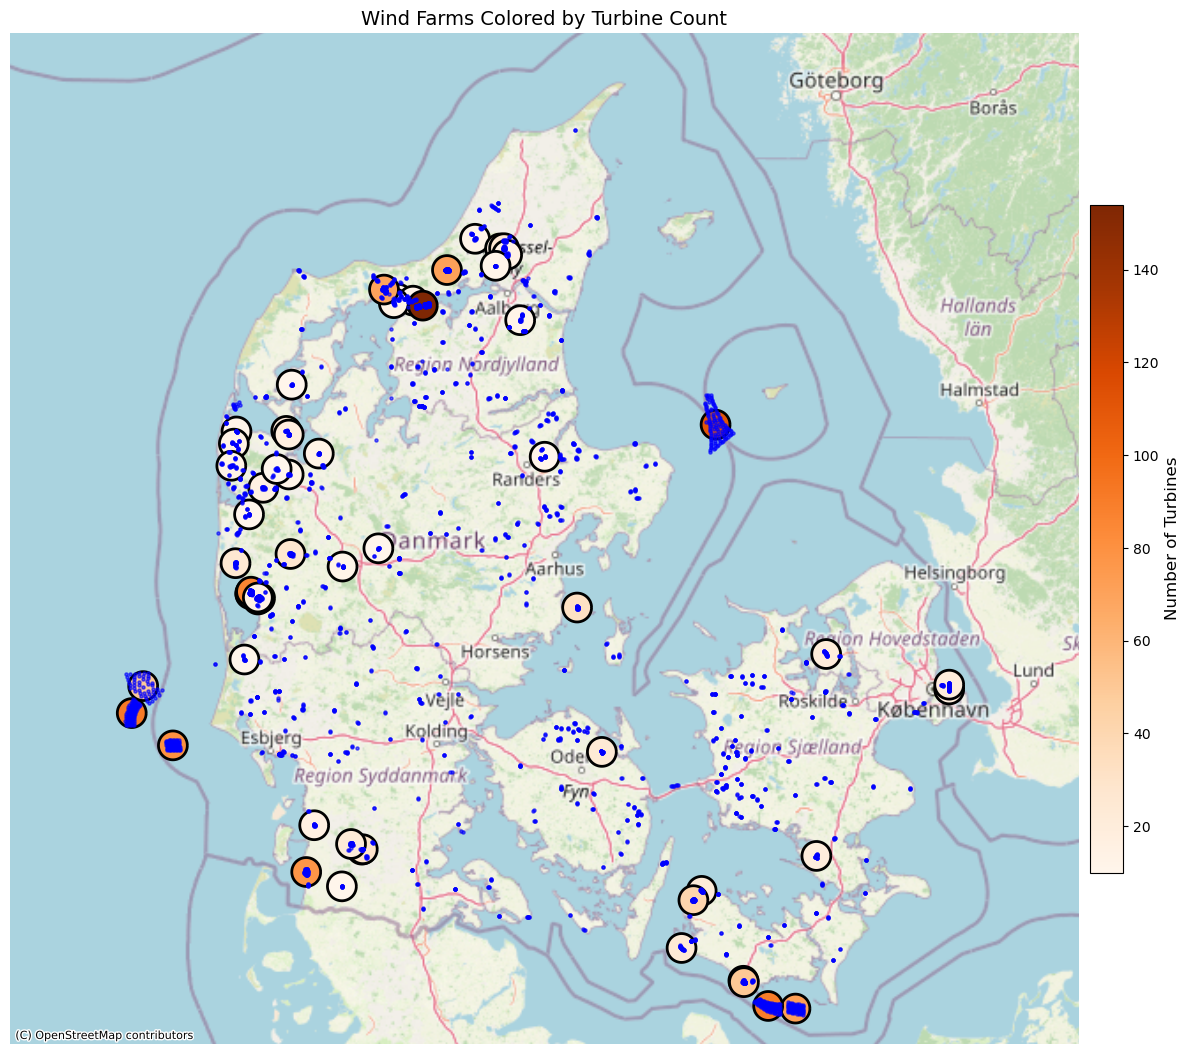

In [175]:
from shapely.geometry import MultiPoint
import matplotlib.cm as cm


# 筛选 M 类风机
m_turbines = gdf[
    (gdf['status'] == 'Available') &
    (gdf['Turbine_type'] == 'M') &
    (gdf.geometry.notnull()) &
    (gdf.geometry.apply(lambda geom: geom.is_valid and not geom.is_empty))
].copy()

# 转换坐标系为 Web Mercator
m_turbines = m_turbines.to_crs(epsg=3857)

# 只保留风机数 ≥ 10 的风场
grouped = m_turbines.groupby('Parent_GSRN')
qualified_groups = {gsrn: group for gsrn, group in grouped if len(group) >= 10}

# 构建 buffer（固定半径 3000m）
# 假设你已经有 m_turbines，并按 Parent_GSRN 分组
turbine_counts = m_turbines.groupby("Parent_GSRN").size().to_dict()

# 创建 buffer_gdf 的同时加上 count 列
buffers = []
for gsrn, group in m_turbines.groupby('Parent_GSRN'):
    points = [pt for pt in group.geometry if pt is not None and pt.is_valid]
    if len(points) >= 10:  # 只保留风机数 ≥10 的风场
        center = MultiPoint(points).centroid
        buffers.append({
            'Parent_GSRN': gsrn,
            'geometry': center.buffer(10000),  # 固定半径 10km
            'count': len(points)               # 添加风机数量
        })

# 创建 GeoDataFrame
buffer_gdf = gpd.GeoDataFrame(buffers, crs=m_turbines.crs)


# 计算颜色映射
cmap = cm.Oranges
norm = mcolors.Normalize(vmin=buffer_gdf['count'].min(), vmax=buffer_gdf['count'].max())
buffer_gdf['color'] = buffer_gdf['count'].apply(lambda x: cmap(norm(x)))

# 可视化
fig, ax = plt.subplots(figsize=(12, 14))

# 绘制 buffer 圆圈
buffer_gdf.plot(
    ax=ax,
    facecolor=buffer_gdf['color'],
    edgecolor='black',
    linewidth=2,
    alpha=1
)

# 绘制风机点
m_turbines.plot(ax=ax, color='blue', markersize=5, alpha=0.6, label='Turbine in Park (M)')

# 地图范围
ax.set_xlim(760000, 1500000)
ax.set_ylim(7250000, 7950000)

# 添加底图
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# 添加 colorbar 图例
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []  # 空数据用于 colorbar
cbar = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.01)
cbar.set_label("Number of Turbines", fontsize=12)

# 图标题和美化
plt.title("Wind Farms Colored by Turbine Count", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

In [168]:

# 自定义区间（比如 6 个区间）
bins = np.linspace(buffer_gdf['count'].min(), buffer_gdf['count'].max(), num=7)
labels = [f"{int(bins[i])}–{int(bins[i+1])}" for i in range(len(bins)-1)]

# 分箱并计数
buffer_gdf['count_bin'] = pd.cut(buffer_gdf['count'], bins=bins, labels=labels, include_lowest=True)
bin_counts = buffer_gdf['count_bin'].value_counts().sort_index()

# 打印结果
print("风场数量按风机数量区间统计：")
for label, count in bin_counts.items():
    print(f"{label}: {count} 个风场")
    
print(f"\n 总风场数: {buffer_gdf.shape[0]} 个")

风场数量按风机数量区间统计：
10–34: 45 个风场
34–58: 3 个风场
58–82: 6 个风场
82–106: 3 个风场
106–130: 1 个风场
130–154: 1 个风场

 总风场数: 59 个


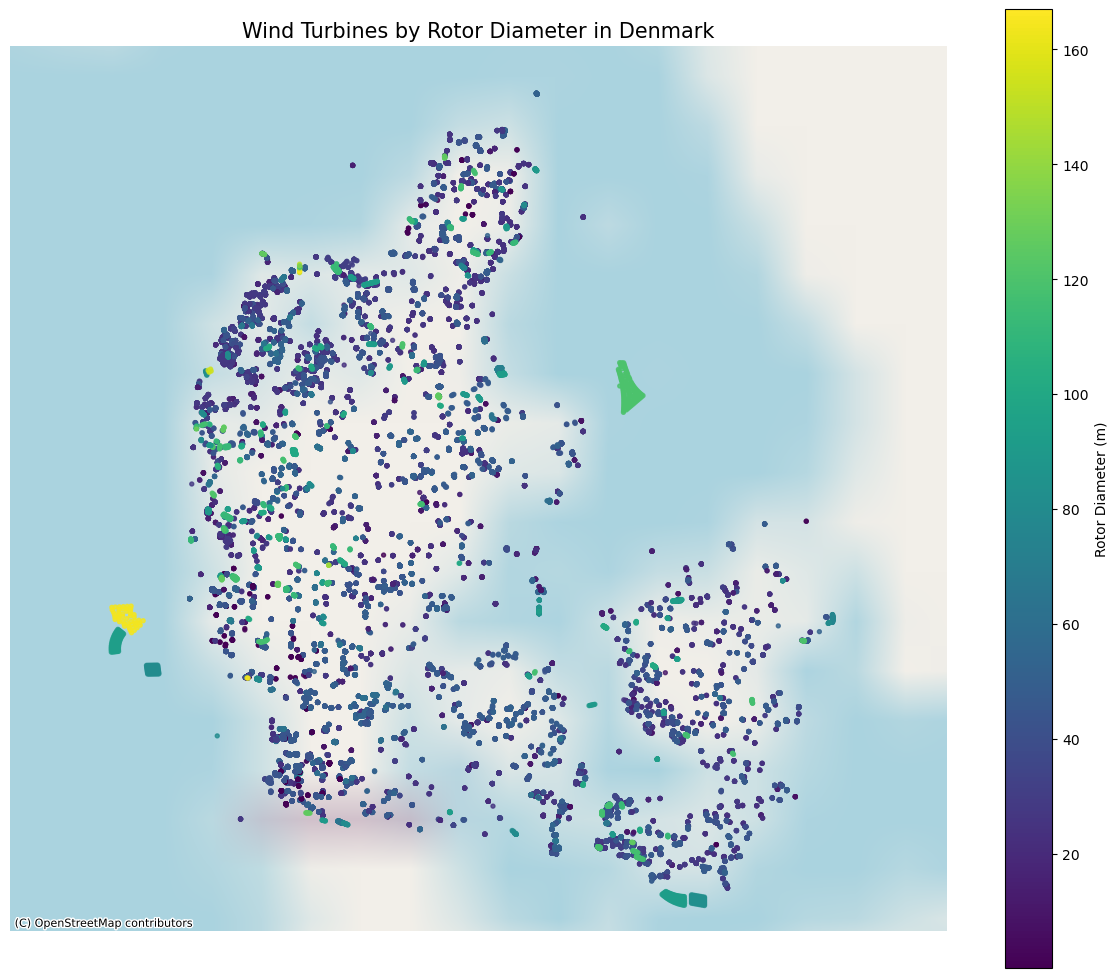

In [182]:
# 1. 筛选可用风机 + 转子直径有效 + 几何存在
rotor_data = gdf[
    (gdf['status'] == 'Available') &
    (gdf['Rotor_diameter'].notnull()) &
    (gdf['Turbine_type'].isin(['M','W']))&
    (gdf.geometry.notnull()) &
    (gdf['Rotor_diameter'] > 0)
].copy()

# 2. 转换为 Web Mercator
rotor_data = rotor_data.to_crs(epsg=3857)

# 3. 颜色映射
cmap = cm.viridis
norm = mcolors.Normalize(
    vmin=rotor_data['Rotor_diameter'].min(), 
    vmax=rotor_data['Rotor_diameter'].max()
)

# 4. 绘图
fig, ax = plt.subplots(figsize=(12, 14))
rotor_data.plot(
    ax=ax,
    column='Rotor_diameter',
    cmap=cmap,
    markersize=8,
    alpha=0.8,
    legend=True,
    legend_kwds={
        'label': "Rotor Diameter (m)",
        'shrink': 0.7,
        'orientation': 'vertical'
    }
)

# 添加底图
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# 图形美化
ax.set_xlim(760000, 1500000)
ax.set_ylim(7250000, 7950000)
plt.title("Wind Turbines by Rotor Diameter in Denmark", fontsize=15)
plt.axis("off")
plt.tight_layout()
plt.show()

In [179]:

# 从 rotor_data 中提取 rotor diameter 列
rotor_diameters = rotor_data['Rotor_diameter']

# 自定义分箱区间（你可以根据数据范围修改）
bins = [0, 40, 60, 80, 100, 120, rotor_diameters.max()]
labels = [f"{int(bins[i])}–{int(bins[i+1])} m" for i in range(len(bins)-1)]

# 分箱
rotor_data['rotor_bin'] = pd.cut(rotor_diameters, bins=bins, labels=labels, include_lowest=True)

# 统计每个区间的数量
rotor_bin_counts = rotor_data['rotor_bin'].value_counts().sort_index()

# 打印结果
print("按转子直径区间统计的风机数量：")
for label, count in rotor_bin_counts.items():
    print(f"{label}: {count} 台风机")

按转子直径区间统计的风机数量：
0–40 m: 20310 台风机
40–60 m: 31644 台风机
60–80 m: 2390 台风机
80–100 m: 1441 台风机
100–120 m: 1284 台风机
120–167 m: 171 台风机
